<a href="https://colab.research.google.com/github/mcnica89/Markov-Chains-RL-W24/blob/main/Temporal_Difference_Learning_Drunkards_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import itertools
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random as jrandom
from jax import nn as jnn
from jax import jit
import random
import time
import timeit
import math
import numpy as np

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
font = {'size'   : 20}

plt.rc('font', **font)

# Gambler's Ruin (aka Drunkard's Walk)

Consider the statespace $[[0,N_{target}]] \subset \mathbb{Z}$ which represetnt possible values for a gambler's wealth. Let $X_n$ be a Markov chain representing the Gambler's wealth after $n$ bets. If they have no money, $0$, then they cannot make any bets:

$$P( X_{n+1} = 0 | X_n = 0) =1$$

If they reach their target $N_{target}$, then they choose to stop gambling.


$$P( X_{n+1} = N_{target} | X_n = N_{target}) =1$$

Otherwise, they bet and their fortune goes up or down by exactly $1$:

$$P( X_{n+1} = x+1 | X_n = x) =p$$
$$P( X_{n+1} = x-1 | X_n = x) =1-p$$

The gambler keeps playing until they either go broke or reach their target. Assume the Gambler gains a reward of 1 life point if they get to $N_{target}$ and the gain a reward of 0 if they reach their target. Determine

$$E[\text{Reward}|X_0 = x] = P(\text{Reach target}|X_0 = x)$$


# Monte Carlo Method

In [33]:
def gamblers_ruin_next_state(current_state,bet_size):
  coin_flip = np.random.choice([-1,+1]) #fair coinflip
  new_state = current_state + bet_size*coin_flip
  return int(new_state)

In [34]:
def monte_carlo_method(learning_rate, policy, N_episodes, N_target):
  #initialize our value functions and number of visits
  value_function = np.zeros(N_target+1)

  exact_answer = np.arange(N_target+1)/N_target #exact answer for the value function
  error_history = np.zeros(N_episodes)

  #simulate N_episode episodes
  for episode_num in range(N_episodes):
    x_0 = np.random.randint(1,N_target-1)
    current_state = x_0
    current_time = 0
    max_time = 1000 #when to stop the simulartion

    #initialize the history of what happened in this episode for states and rewards
    state_history = np.zeros(max_time+1,dtype=int)
    reward_history = np.zeros(max_time+1)

    episode_is_over = False
    while not episode_is_over:
      state_history[current_time] = current_state
      if current_state==0 or current_state==N_target or current_time >= max_time:
        reward_history[current_time] = (current_state==N_target) #reward of +1 if you reach the final location.
        t_final = current_time
        episode_is_over = True
      else:
        reward_history[current_time] = 0

      #THIS IS THE MOST IMPORTANT LINE OF PART I:
      current_state = gamblers_ruin_next_state(current_state,policy[int(current_state)])
      current_time +=1

    #PART II
    #Now update the value function for states we saw this episode
    #We are using the first visit monte carlo rule!

    #Array to keep track of which states we've visited
    visited_already = np.zeros(N_target+1,dtype=bool)
    for t in range(0,t_final+1):
      state = state_history[t]
      if visited_already[state] == False:
        G = np.sum(reward_history[t:t_final+1])

        #constant alpha learning
        value_function[state] += learning_rate*(G - value_function[state])

        visited_already[state] = True

    error_history[episode_num] = np.mean(np.abs(value_function - exact_answer))

  return value_function, error_history

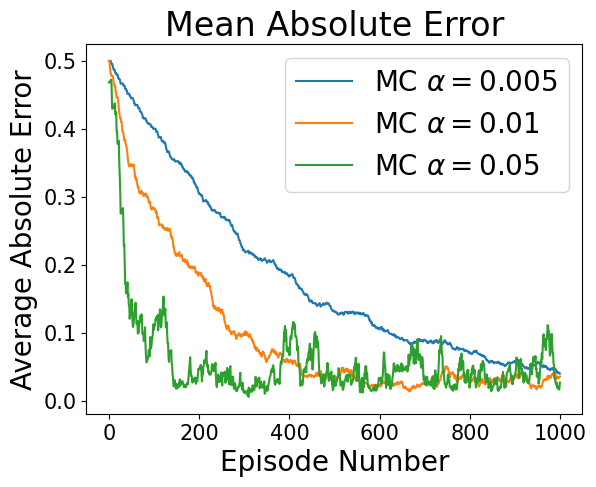

In [36]:
N = 10
alpha = 0.01

plt.title("Mean Absolute Error")
plt.xlabel("Episode Number")
plt.ylabel("Average Absolute Error")
for alpha in [0.005,0.01,0.05]:
  v, error_history = monte_carlo_method(learning_rate=alpha,policy = np.ones(N+1),N_episodes = 1000, N_target = N)
  plt.plot(error_history,label=f"MC $\\alpha=${alpha}")
plt.legend()

# TD0 Method (Temperal Difference Learning with 0 memory)

In [43]:
def TD0_method(learning_rate, policy, N_episodes, N_target):
  exact_answer = np.arange(N_target+1)/N_target #exact answer for the value function
  error_history = np.zeros(N_episodes)

  value_func = np.zeros(N_target+1)
  value_func[N_target] = 1

  for episode_num in range(N_episodes):
    current_state = np.random.randint(1,N_target-1)
    episode_is_over = False

    while not episode_is_over:
      new_state = gamblers_ruin_next_state(current_state,policy[current_state])
      delta_value = value_func[new_state] - value_func[current_state]
      value_func[current_state] += learning_rate*( delta_value  )
      current_state = new_state

      if current_state == 0 or current_state == N_target:
        episode_is_over = True


    error_history[episode_num] = np.mean(np.abs(value_func - exact_answer))

  return value_func, error_history

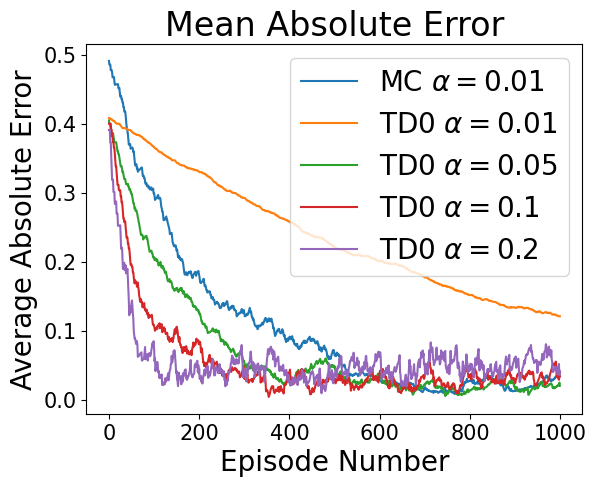

In [50]:
plt.title("Mean Absolute Error")
plt.xlabel("Episode Number")
plt.ylabel("Average Absolute Error")
for alpha in [0.01]:
  v, error_history = monte_carlo_method(learning_rate=alpha,policy = np.ones(N+1),N_episodes = 1000, N_target = N)
  plt.plot(error_history,label=f"MC $\\alpha=${alpha}")

for alpha in [0.01,0.05,0.1,0.2]:
  v,error_history = TD0_method(learning_rate=alpha, policy=np.ones(10), N_episodes=1000, N_target=10)
  plt.plot(error_history,label=f"TD0 $\\alpha=${alpha}")

plt.legend()



# TD n
Update according to n steps ago

In [89]:
def TDn_method(learning_rate, policy, N_episodes, N_target,n=1):
  exact_answer = np.arange(N_target+1)/N_target #exact answer for the value function
  error_history = np.zeros(N_episodes)

  value_func = np.zeros(N_target+1)
  value_func[N_target] = 1


  for episode_num in range(N_episodes):
    current_state = np.random.randint(1,N_target-1)
    episode_is_over = False
    last_n_states = [] #history of the last n values we've seen in this path


    while not episode_is_over:
      current_state = gamblers_ruin_next_state(current_state,policy[current_state])
      last_n_states.append(current_state)

      if current_state == 0 or current_state == N_target:
        for state in last_n_states:
          delta_value = value_func[current_state] - value_func[state]
          value_func[state] += learning_rate*( delta_value  )
        episode_is_over = True
      else:
        if len(last_n_states) > n:
          state_n_steps_ago = last_n_states.pop(0) #pull of the value from n rounds ago
          delta_value = value_func[current_state] - value_func[state_n_steps_ago]
          value_func[state_n_steps_ago] += learning_rate*( delta_value  )


    error_history[episode_num] = np.mean(np.abs(value_func - exact_answer))

  return value_func, error_history

[0.         0.02331314 0.06097425 0.11388288 0.18540091 0.26623176
 0.36359564 0.49739045 0.6324178  0.79782454 1.        ]
[0.         0.05634803 0.14000165 0.2050502  0.31710148 0.40993139
 0.53020053 0.63454154 0.76393895 0.85683205 1.        ]
[0.         0.09838132 0.18102033 0.30749378 0.39854002 0.51798139
 0.62152371 0.71345462 0.81343828 0.91735497 1.        ]
[0.         0.08909504 0.17080338 0.27266973 0.38411763 0.45772789
 0.57464125 0.68627401 0.78726385 0.87348803 1.        ]


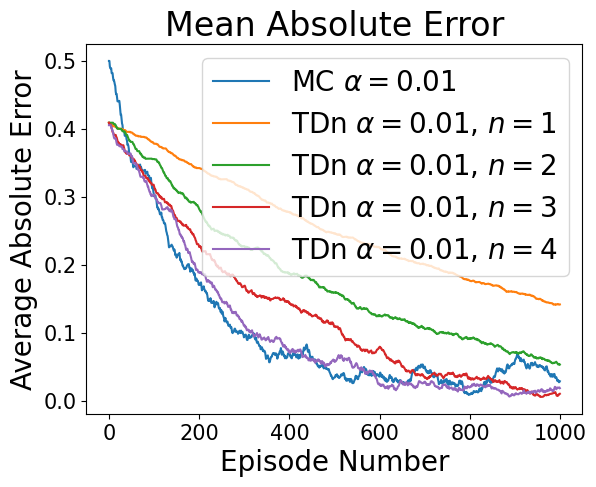

In [90]:
plt.title("Mean Absolute Error")
plt.xlabel("Episode Number")
plt.ylabel("Average Absolute Error")
for alpha in [0.01]:
  v, error_history = monte_carlo_method(learning_rate=alpha,policy = np.ones(N+1),N_episodes = 1000, N_target = N)
  plt.plot(error_history,label=f"MC $\\alpha=${alpha}")

for my_n in [1,2,3,4]:
  alpha = 0.01
  #v,error_history = TD0_method(learning_rate=alpha, policy=np.ones(10), N_episodes=1000, N_target=10)
  v,error_history = TDn_method(learning_rate=alpha, policy=np.ones(10), N_episodes=1000, N_target=10,n=my_n)
  print(v)
  plt.plot(error_history,label=f"TDn $\\alpha=${alpha}, $n=${my_n}")

plt.legend()


#Time comparisons

In [51]:
my_N_target=10
my_N_episodes=100_000
alpha = 0.1

In [52]:
%time monte_carlo_method(learning_rate=alpha,policy = np.ones(my_N_target+1),N_episodes = my_N_episodes, N_target = my_N_target)

CPU times: user 49.2 s, sys: 2.47 s, total: 51.7 s
Wall time: 51.3 s


(array([0.        , 0.09527861, 0.11929503, 0.22470958, 0.3105024 ,
        0.3423118 , 0.47990613, 0.64300745, 0.7403199 , 0.79156512,
        1.        ]),
 array([0.5       , 0.5       , 0.40909091, ..., 0.07868107, 0.06509318,
        0.068464  ]))

In [54]:
%time TD0_method(learning_rate=alpha,policy = np.ones(my_N_target+1),N_episodes = my_N_episodes, N_target = my_N_target)

CPU times: user 34.8 s, sys: 2.23 s, total: 37.1 s
Wall time: 35.8 s


(array([0.        , 0.06077681, 0.15017095, 0.31446011, 0.36602143,
        0.51936398, 0.6055721 , 0.67740711, 0.80051786, 0.89215112,
        1.        ]),
 array([0.40909091, 0.4       , 0.39090909, ..., 0.01572542, 0.01523749,
        0.0175806 ]))